<div style='text-align: center;'>
    <img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSQzJzIHdangJTrH2mFXFgsLjuLCjpfXXwbxg&usqp=CAU' width='100'/>
    <h1>Sharif University of Technology</h1>
    <h2>Machine Learning</h2>
    <h3>Project</h3>
    <h4>ML Privacy</h4>
    <p><strong>Author:</strong> Ali Nikkhah</p>
</div>
<hr/>


In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.optim import Adam
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Subset
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import mode
from torchvision import datasets, transforms
from pprint import pprint
import os
import torch
import torchvision
from torch.optim import Adam
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torchvision.models import resnet18
from prettytable import PrettyTable
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import random
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam  # Ensure this import is included
import numpy as np
from torch.utils.data import Dataset, Subset


# Load, Define, Modify Model

Load and Modify ResNet Model

In [2]:
# Load and modify the model to classify CIFAR-10 images
def get_model(device):
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust for CIFAR-10 which has 10 classes
    model = model.to(device)  # Move the model to the GPU
    return model


Implement the SISA Training Methodology

In [3]:

# Mock dataset class for testing
class MockDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Shard the dataset into S shards
def shard_data(dataset, S):
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    shard_size = len(dataset) // S
    shards = [Subset(dataset, indices[i*shard_size:(i+1)*shard_size]) for i in range(S)]
    return shards

# Slice the shard into R slices
def slice_shard(shard, R):
    indices = list(range(len(shard)))
    np.random.shuffle(indices)
    slice_size = len(shard) // R
    slices = [Subset(shard, indices[i*slice_size:(i+1)*slice_size]) for i in range(R)]
    return slices


# Test the shard_data function
def test_shard_data():
    # Create a mock dataset with 100 samples
    data = list(range(100))
    dataset = MockDataset(data)
    
    # Shard the dataset into 5 shards
    S = 5
    shards = shard_data(dataset, S)
    
    # Check the number of shards
    assert len(shards) == S, f"Expected {S} shards, but got {len(shards)}"
    
    # Check the size of each shard
    expected_shard_size = len(dataset) // S
    for i, shard in enumerate(shards):
        assert len(shard) == expected_shard_size, f"Shard {i} size is {len(shard)}, but expected {expected_shard_size}"
    
    # Check the contents of the shards (indices should be shuffled and unique)
    all_indices = []
    for shard in shards:
        all_indices.extend(shard.indices)
    
    all_indices_set = set(all_indices)
    assert len(all_indices) == len(dataset), "The total number of indices is incorrect"
    assert len(all_indices) == len(all_indices_set), "There are duplicate indices in the shards"
    assert all(idx in all_indices_set for idx in range(len(dataset))), "Some indices are missing in the shards"
    
    print("All tests passed!")

# Run the test
test_shard_data()


All tests passed!


Train Function for each Model

In [4]:
import torch

def train_model(trainloader, model, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Handling batch normalization for single-item batches
            if inputs.size(0) < 3:
                model.eval()  # Switch to evaluation mode for single-item batches
                with torch.no_grad():
                    outputs = model(inputs)
                loss = criterion(outputs, labels)
            else:
                model.train()  # Ensure model is in training mode for normal batches
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()


Evaluation function for each model

In [5]:
def calculate_metrics(true_labels, preds, probs):
    accuracy = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds, average='weighted')
    recall = recall_score(true_labels, preds, average='weighted')
    f1 = f1_score(true_labels, preds, average='weighted')
    try:
        auroc = roc_auc_score(true_labels, probs, average='weighted', multi_class='ovr')
    except ValueError:
        auroc = float('nan')  # Handle the case where ROC AUC cannot be calculated
    return accuracy, precision, recall, f1, auroc

In [6]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            outputs = model(inputs)
            all_preds.append(outputs)
    return torch.cat(all_preds)

In [7]:
# Full Integration with the Updated Aggregation Methods
def simple_average(models, loader, device):
    predictions = [torch.softmax(get_predictions(model, loader, device), dim=1) for model in models]
    mean_preds = torch.mean(torch.stack(predictions), dim=0)
    return torch.argmax(mean_preds, dim=1)

def weighted_average(models, loader, weights, device):
    predictions = [torch.softmax(get_predictions(model, loader, device), dim=1) * weight for model, weight in zip(models, weights)]
    weighted_preds = torch.sum(torch.stack(predictions), dim=0)
    return torch.argmax(weighted_preds, dim=1)

def bayesian_model_averaging(models, loader, posterior_probabilities, device):
    predictions = [torch.softmax(get_predictions(model, loader, device), dim=1) * p for model, p in zip(models, posterior_probabilities)]
    bma_preds = torch.sum(torch.stack(predictions), dim=0)
    return torch.argmax(bma_preds, dim=1)
def majority_voting(models, loader, device):
    predictions = [torch.argmax(get_predictions(model, loader, device), dim=1) for model in models]
    stacked_preds = torch.stack(predictions).T
    voted_preds, _ = mode(stacked_preds.cpu().numpy(), axis=1)
    return torch.tensor(voted_preds.squeeze(), dtype=torch.long)


In [8]:
def calculate_shard_accuracies(models, testloader, device):
    accuracies = []
    for model in models:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        accuracies.append(accuracy)
    return accuracies

def evaluate_aggregated_models(model_paths, testloader, device):
    models = load_models(model_paths, device)
    true_labels = []
    
    # Collect true labels
    for data in testloader:
        _, labels = data
        true_labels.extend(labels.cpu().numpy())
    
    true_labels = np.array(true_labels)
    
    # Calculate shard accuracies for weighted averaging
    shard_accuracies = calculate_shard_accuracies(models, testloader, device)

    aggregated_results = {}
    aggregation_methods = {
        'Simple Average': simple_average,
        'Weighted Average': lambda models, loader, device: weighted_average(models, loader, shard_accuracies, device),
        'Majority Voting': majority_voting
    }
    
    with tqdm(total=len(aggregation_methods), desc="Aggregating Results", leave=False) as pbar:
        for method_name, method_func in aggregation_methods.items():
            preds = method_func(models, testloader, device).cpu().numpy()
            probs = torch.softmax(get_predictions(models[0], testloader, device), dim=1).cpu().numpy()
            accuracy, precision, recall, f1, auroc = calculate_metrics(true_labels, preds, probs)
            aggregated_results[method_name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'AUROC': auroc
            }
            pbar.update(1)

    return aggregated_results

In [9]:

def load_models(model_paths, device):
    models = []
    for path in model_paths:
        model = get_model(device)
        model.load_state_dict(torch.load(path))
        model.to(device)
        models.append(model)
    return models

In [10]:
# Evaluate the model
def evaluate_model(dataloader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    auroc = roc_auc_score(np.eye(10)[all_labels], np.eye(10)[all_preds], multi_class='ovr')

    return accuracy, precision, recall, f1, auroc

Run Simulations for Different S and R

In [11]:


def train_and_save_models(shard_counts, slice_counts, trainset, testloader, device, subset_name=''):
    results = []
    model_directory = f"./models{subset_name}"
    os.makedirs(model_directory, exist_ok=True)

    total_steps = sum(shard_counts) * sum(slice_counts)
    with tqdm(total=total_steps, desc="Training Progress", unit="step", leave=False) as pbar:
        for S in shard_counts:
            for R in slice_counts:
                shards = shard_data(trainset, S)
                shard_models = []
                print(f"Training with {S} shards and {R} slices per shard")

                for i, shard in enumerate(shards):
                    model_path = f"{model_directory}/model_S{S}_R{R}_shard{i}.pth"
                    # Check if the model already exists
                    if os.path.exists(model_path):
                        print(f"Model at {model_path} already exists. Skipping training.")
                        model = get_model(device)
                        model.load_state_dict(torch.load(model_path))
                        model.to(device)
                        shard_models.append(model_path)
                        pbar.update(1)
                        continue  # Skip to the next iteration
                    
                    # Model does not exist, proceed with training
                    model = get_model(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = Adam(model.parameters(), lr=0.001)
                    combined_dataset = []

                    for slice_ in shard_data(shard, R):
                        combined_dataset.extend(slice_.indices)
                        combined_subset = Subset(shard, combined_dataset)
                        trainloader = DataLoader(combined_subset, batch_size=64, shuffle=True)
                        train_model(trainloader, model, criterion, optimizer, 1,device)

                    torch.save(model.state_dict(), model_path)
                    shard_models.append(model_path)
                    pbar.update(1)

                # Evaluate and aggregate results after training or loading
                aggregated_results = evaluate_aggregated_models(shard_models, testloader, device)
                accuracy, precision, recall, f1, auroc = evaluate_model(testloader, model, device)
                results.append({
                    'S': S,
                    'R': R,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'AUROC': auroc,
                    'Model_Paths': shard_models,
                    'Aggregated_Results': aggregated_results
                })

    return results



# Load, Preprocess, Exploratory Analysis


Load and Preprocess

In [12]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


Setting Up the GPU

In [13]:
import torch

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load and Visualize CIFAR-10 Data

100%|██████████| 170498071/170498071 [00:08<00:00, 20876717.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


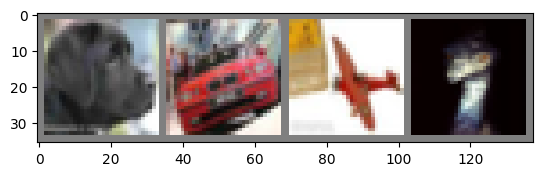

In [14]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Displaying images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(DataLoader(trainset, batch_size=4, shuffle=True))
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

Plot the Distribution of Labels

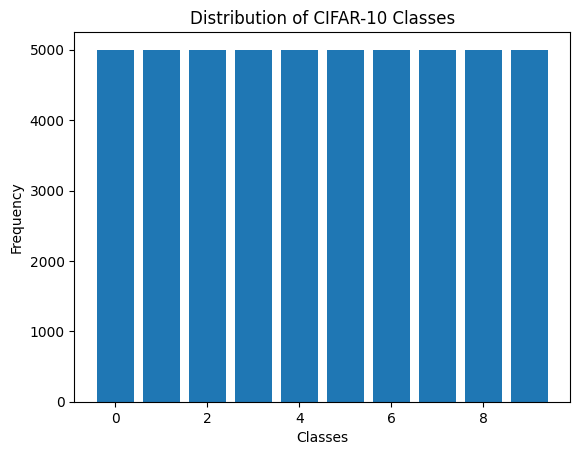

In [15]:
# Count label occurrences
label_counts = np.zeros(10)
for _, label in trainset:
    label_counts[label] += 1

# Plotting
plt.bar(range(10), label_counts)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Distribution of CIFAR-10 Classes')
plt.show()

# Training the model

In [16]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

In [ ]:
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [18]:
shard_counts = [5,10,20]
slice_counts = [5,10,20]

In [20]:

results = train_and_save_models(shard_counts=shard_counts, slice_counts=slice_counts, trainset=trainset, testloader=testloader, device=device)


Training Progress:   0%|          | 0/1225 [00:00<?, ?step/s]

Training with 5 shards and 5 slices per shard
Model at ./models/model_S5_R5_shard0.pth already exists. Skipping training.
Model at ./models/model_S5_R5_shard1.pth already exists. Skipping training.
Model at ./models/model_S5_R5_shard2.pth already exists. Skipping training.
Model at ./models/model_S5_R5_shard3.pth already exists. Skipping training.
Model at ./models/model_S5_R5_shard4.pth already exists. Skipping training.


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training with 5 shards and 10 slices per shard
Model at ./models/model_S5_R10_shard0.pth already exists. Skipping training.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model at ./models/model_S5_R10_shard1.pth already exists. Skipping training.
Model at ./models/model_S5_R10_shard2.pth already exists. Skipping training.
Model at ./models/model_S5_R10_shard3.pth already exists. Skipping training.
Model at ./models/model_S5_R10_shard4.pth already exists. Skipping training.


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training with 5 shards and 20 slices per shard
Model at ./models/model_S5_R20_shard0.pth already exists. Skipping training.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model at ./models/model_S5_R20_shard1.pth already exists. Skipping training.
Model at ./models/model_S5_R20_shard2.pth already exists. Skipping training.
Model at ./models/model_S5_R20_shard3.pth already exists. Skipping training.
Model at ./models/model_S5_R20_shard4.pth already exists. Skipping training.


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training with 10 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training with 10 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training with 10 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training with 20 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training with 20 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training with 20 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [24]:
def print_results_pretty(results):
    table = PrettyTable()
    table.field_names = ["S", "R", "Accuracy", "Precision", "Recall", "F1", "AUROC"]

    for result in results:
        table.add_row([
            result['S'],
            result['R'],
            f"{result['Accuracy']:.4f}",
            f"{result['Precision']:.4f}",
            f"{result['Recall']:.4f}",
            f"{result['F1']:.4f}",
            f"{result['AUROC']:.4f}"
        ])

    print(table)
# Print training results
print("Training Results:")
print_results_pretty(results)

Training Results:
+----+----+----------+-----------+--------+--------+--------+
| S  | R  | Accuracy | Precision | Recall |   F1   | AUROC  |
+----+----+----------+-----------+--------+--------+--------+
| 5  | 5  |  0.6803  |   0.7106  | 0.6803 | 0.6814 | 0.8224 |
| 5  | 10 |  0.6849  |   0.7193  | 0.6849 | 0.6827 | 0.8249 |
| 5  | 20 |  0.6999  |   0.7124  | 0.6999 | 0.6980 | 0.8333 |
| 10 | 5  |  0.6293  |   0.6610  | 0.6293 | 0.6252 | 0.7941 |
| 10 | 10 |  0.6570  |   0.6792  | 0.6570 | 0.6590 | 0.8094 |
| 10 | 20 |  0.6718  |   0.6833  | 0.6718 | 0.6716 | 0.8177 |
| 20 | 5  |  0.5584  |   0.5828  | 0.5584 | 0.5534 | 0.7547 |
| 20 | 10 |  0.5913  |   0.6263  | 0.5913 | 0.5811 | 0.7729 |
| 20 | 20 |  0.6384  |   0.6490  | 0.6384 | 0.6341 | 0.7991 |
+----+----+----------+-----------+--------+--------+--------+


In [122]:
def print_aggregated_results_pretty(results):
    table = PrettyTable()
    table.field_names = ["S", "R", "Method", "Accuracy", "Precision", "Recall", "F1", "AUROC", "ASR"]

    for result in results:
        S = result['S']
        R = result['R']
        aggregated_results = result['Aggregated_Results']
        asr = result['asr']
        
        # It is assumed each aggregation method includes ASR if available, otherwise 'N/A'
        for method, metrics in aggregated_results.items():
            table.add_row([
                S,
                R,
                method,
                f"{metrics['Accuracy']:.4f}",
                f"{metrics['Precision']:.4f}",
                f"{metrics['Recall']:.4f}",
                f"{metrics['F1']:.4f}",
                f"{metrics['AUROC']:.4f}",
                f"{asr:.4f}" if asr != 'N/A' else asr
            ])

    print(table)


In [26]:

print("Aggregated Results:")
print_aggregated_results_pretty(results)


Aggregated Results:
+----+----+------------------+----------+-----------+--------+--------+--------+-----+
| S  | R  |      Method      | Accuracy | Precision | Recall |   F1   | AUROC  | ASR |
+----+----+------------------+----------+-----------+--------+--------+--------+-----+
| 5  | 5  |  Simple Average  |  0.7824  |   0.7929  | 0.7824 | 0.7841 | 0.9515 | N/A |
| 5  | 5  | Weighted Average |  0.7819  |   0.7925  | 0.7819 | 0.7836 | 0.9515 | N/A |
| 5  | 5  | Majority Voting  |  0.7659  |   0.7827  | 0.7659 | 0.7685 | 0.9515 | N/A |
| 5  | 10 |  Simple Average  |  0.7928  |   0.8022  | 0.7928 | 0.7933 | 0.9547 | N/A |
| 5  | 10 | Weighted Average |  0.7927  |   0.8019  | 0.7927 | 0.7933 | 0.9547 | N/A |
| 5  | 10 | Majority Voting  |  0.7781  |   0.7923  | 0.7781 | 0.7797 | 0.9547 | N/A |
| 5  | 20 |  Simple Average  |  0.8080  |   0.8067  | 0.8080 | 0.8069 | 0.9530 | N/A |
| 5  | 20 | Weighted Average |  0.8076  |   0.8062  | 0.8076 | 0.8065 | 0.9530 | N/A |
| 5  | 20 | Majority Vo

# Simulation #2: UNLEARNING

In [29]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset


def unlearn_data(shard_counts, slice_counts, trainset, testloader, device, forget_indices, subset_name=''):
    model_directory = f"./models{subset_name}"
    os.makedirs(model_directory, exist_ok=True)

    results = []
    total_steps = sum(shard_counts) * sum(slice_counts)
    
    with tqdm(total=total_steps, desc="Unlearning Progress", unit="step", leave=False) as pbar:
        for S in shard_counts:
            for R in slice_counts:
                shards = shard_data(trainset, S)
                shard_models = []
                print(f"Unlearning with {S} shards and {R} slices per shard")

                for i, shard in enumerate(shards):
                    slices = slice_shard(shard, R)
                    model_path = f"{model_directory}/model_S{S}_R{R}_shard{i}.pth"
                    unlearned_model_path = f"{model_directory}/model_S{S}_R{R}_shard{i}_unlearned.pth"
                    
                    if os.path.exists(unlearned_model_path):
                        print(f"Unlearned model at {unlearned_model_path} already exists. Skipping unlearning.")
                        model = get_model(device)
                        model.load_state_dict(torch.load(unlearned_model_path))
                        model.to(device)
                        shard_models.append(unlearned_model_path)
                        continue  # Skip to the next iteration if unlearned model already exists

                    if not os.path.exists(model_path):
                        continue  # Skip if no original model is found

                    # Load the original model
                    model = get_model(device)
                    model.load_state_dict(torch.load(model_path))
                    model.to(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=0.001)

                    for slice_ in slices:
                        # Filter indices to exclude the forgotten ones
                        filtered_indices = [idx for idx in slice_.indices if idx not in forget_indices]
                        if not filtered_indices:
                            continue  # Skip training if no indices remain after filtering

                        combined_subset = Subset(trainset, filtered_indices)
                        trainloader = DataLoader(combined_subset, batch_size=32, shuffle=True)

                        train_model(trainloader, model, criterion, optimizer, 1,device)
                        pbar.update(1)

                    # Save the unlearned model state
                    torch.save(model.state_dict(), unlearned_model_path)
                    shard_models.append(unlearned_model_path)

                # Evaluate and aggregate results after unlearning
                if shard_models:  # Ensure there are models to evaluate
                    aggregated_results = evaluate_aggregated_models(shard_models, testloader, device)
                    accuracy, precision, recall, f1, auroc = evaluate_model(testloader, model, device)
                    results.append({
                        'S': S,
                        'R': R,
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'AUROC': auroc,
                        'Model_Paths': shard_models,
                        'Forgotten_Indices': list(forget_indices),
                        'Aggregated_Results': aggregated_results
                    })

    return results


In [30]:
total_data = len(trainset)

forget_count=500

forget_indices = set(random.sample(range(total_data), forget_count))
# Run unlearning phase
unlearn_results = unlearn_data(shard_counts, slice_counts, trainset, testloader, device,forget_indices)


Unlearning Progress:   0%|          | 0/1225 [00:00<?, ?step/s]

Unlearning with 5 shards and 5 slices per shard


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Unlearning with 5 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Unlearning with 5 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Unlearning with 10 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Unlearning with 10 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Unlearning with 10 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Unlearning with 20 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Unlearning with 20 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Unlearning with 20 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [31]:
print("Unlearning Results:")
print_results_pretty(unlearn_results)

Unlearning Results:
+----+----+----------+-----------+--------+--------+--------+
| S  | R  | Accuracy | Precision | Recall |   F1   | AUROC  |
+----+----+----------+-----------+--------+--------+--------+
| 5  | 5  |  0.6040  |   0.6730  | 0.6040 | 0.5999 | 0.7800 |
| 5  | 10 |  0.6644  |   0.6819  | 0.6644 | 0.6602 | 0.8136 |
| 5  | 20 |  0.7160  |   0.7240  | 0.7160 | 0.7172 | 0.8422 |
| 10 | 5  |  0.6216  |   0.6507  | 0.6216 | 0.6262 | 0.7898 |
| 10 | 10 |  0.6196  |   0.6328  | 0.6196 | 0.6098 | 0.7887 |
| 10 | 20 |  0.6535  |   0.6783  | 0.6535 | 0.6538 | 0.8075 |
| 20 | 5  |  0.5949  |   0.6266  | 0.5949 | 0.5850 | 0.7749 |
| 20 | 10 |  0.5882  |   0.6191  | 0.5882 | 0.5857 | 0.7712 |
| 20 | 20 |  0.5919  |   0.6188  | 0.5919 | 0.5816 | 0.7733 |
+----+----+----------+-----------+--------+--------+--------+


In [32]:

# Print unlearning results in a pretty table
print_aggregated_results_pretty(unlearn_results)

+----+----+------------------+----------+-----------+--------+--------+--------+-----+
| S  | R  |      Method      | Accuracy | Precision | Recall |   F1   | AUROC  | ASR |
+----+----+------------------+----------+-----------+--------+--------+--------+-----+
| 5  | 5  |  Simple Average  |  0.7574  |   0.7631  | 0.7574 | 0.7558 | 0.9442 | N/A |
| 5  | 5  | Weighted Average |  0.7568  |   0.7617  | 0.7568 | 0.7551 | 0.9442 | N/A |
| 5  | 5  | Majority Voting  |  0.7426  |   0.7516  | 0.7426 | 0.7422 | 0.9442 | N/A |
| 5  | 10 |  Simple Average  |  0.7804  |   0.7874  | 0.7804 | 0.7813 | 0.9480 | N/A |
| 5  | 10 | Weighted Average |  0.7803  |   0.7875  | 0.7803 | 0.7812 | 0.9480 | N/A |
| 5  | 10 | Majority Voting  |  0.7656  |   0.7779  | 0.7656 | 0.7674 | 0.9480 | N/A |
| 5  | 20 |  Simple Average  |  0.7864  |   0.7950  | 0.7864 | 0.7880 | 0.9565 | N/A |
| 5  | 20 | Weighted Average |  0.7863  |   0.7949  | 0.7863 | 0.7879 | 0.9565 | N/A |
| 5  | 20 | Majority Voting  |  0.7738  |  

# Simulation #3: EVALUATION

### Expected Results:

#### Perfectly Unlearned Model:
- **Concept**: A perfectly unlearned model means that the model has completely forgotten the 'forget set' data, such that it treats this data no differently from any other unseen test data.
- **MIA Score**: For a perfectly unlearned model, the Membership Inference Attack (MIA) score should be close to 0.5. 
  - **Why 0.5?**: A score of 0.5 indicates that the Logistic Regression model, used in the MIA, cannot distinguish between the 'forget set' and the test set better than random guessing.
  - **Interpretation**: This implies that the model's responses to the 'forget set' and the test set are statistically indistinguishable, suggesting effective unlearning.

#### SISA Algorithm Performance:
- **Comparison**: By comparing the MIA scores before and after unlearning, we can evaluate the effectiveness of the SISA algorithm.
  - **Before Unlearning**: The MIA score is expected to be higher than 0.5 because the model has likely overfitted on the training data, including the 'forget set'. The Logistic Regression model can distinguish between the 'forget set' and the test set with higher accuracy.
  - **After Unlearning**: If the SISA algorithm is effective, the MIA score should drop significantly, approaching 0.5.
    - **Significant Drop**: A significant drop in the MIA score indicates that the model's responses to the 'forget set' are no longer distinguishable from its responses to the test set, implying successful unlearning.
- **Effectiveness**: 
  - **High Post-Unlearning Score**: If the MIA score remains high after unlearning, it suggests that the SISA algorithm has not effectively removed the influence of the 'forget set' from the model.
  - **Low Post-Unlearning Score**: Conversely, a low post-unlearning score (close to 0.5) indicates effective unlearning, meaning the SISA algorithm has successfully removed the specified data from the model.

#### Summary:
- **Ideal Scenario**: In an ideal scenario, the MIA score before unlearning is high, reflecting the model's familiarity with the 'forget set'. After unlearning, the MIA score should drop to around 0.5, indicating that the model no longer retains specific information about the 'forget set'.
- **Assessment**: This assessment method allows us to quantify the effectiveness of the SISA algorithm in unlearning specific data, ensuring the model's behavior aligns with privacy expectations.

By evaluating the MIA scores before and after unlearning, we can determine how well the SISA algorithm performs in terms of data unlearning and privacy protection.

In [57]:
def compute_losses(model, dataloader, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels, reduction='none')
            losses.extend(loss.cpu().numpy())
    return losses

In [58]:
def evaluate_mia(forget_losses, test_losses):
    # Combine losses
    losses = np.concatenate((forget_losses, test_losses))
    labels = np.concatenate((np.ones(len(forget_losses)), np.zeros(len(test_losses))))
    
    # Train Logistic Regression model
    mia_model = LogisticRegressionCV(cv=5, max_iter=1000).fit(losses.reshape(-1, 1), labels)
    
    # Evaluate using cross-validation
    cv_scores = mia_model.scores_[1].mean(axis=0)
    
    return cv_scores.mean()

In [59]:
def load_model(model_path, device):
    model = get_model(device)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


test_indices = random.sample(range(len(testloader.dataset)), 500)  # Randomly sample test set

forget_subset = Subset(trainset, forget_indices)
test_subset = Subset(testloader.dataset, test_indices)

forget_loader = DataLoader(forget_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

In [61]:
results=[]

In [63]:
for S in shard_counts:
    for R in slice_counts:
        print(f"Evaluating MIA for S={S}, R={R}")

        # Load the trained model
        trained_model_paths = [f"./models/model_S{S}_R{R}_shard{i}.pth" for i in range(S)]
        trained_models = [load_model(path, device) for path in trained_model_paths]
        
        # Evaluate each shard's model
        trained_forget_losses = []
        trained_test_losses = []
        for model in trained_models:
            trained_forget_losses.extend(compute_losses(model, forget_loader, device))
            trained_test_losses.extend(compute_losses(model, test_loader, device))
        
        # Evaluate MIA on the trained model
        mia_score_trained = evaluate_mia(trained_forget_losses, trained_test_losses)
        print(f"MIA Score on trained model (S={S}, R={R}): {mia_score_trained}")

        # Load the unlearned model
        unlearned_model_paths = [f"./models/model_S{S}_R{R}_shard{i}_unlearned.pth" for i in range(S)]
        unlearned_models = [load_model(path, device) for path in unlearned_model_paths]
        
        # Evaluate each shard's model
        unlearned_forget_losses = []
        unlearned_test_losses = []
        for model in unlearned_models:
            unlearned_forget_losses.extend(compute_losses(model, forget_loader, device))
            unlearned_test_losses.extend(compute_losses(model, test_loader, device))
        
        # Evaluate MIA on the unlearned model
        mia_score_unlearned = evaluate_mia(unlearned_forget_losses, unlearned_test_losses)
        print(f"MIA Score on unlearned model (S={S}, R={R}): {mia_score_unlearned}")

        results.append({
            'S': S,
            'R': R,
            'MIA_Score_Trained': mia_score_trained,
            'MIA_Score_Unlearned': mia_score_unlearned
        })

Evaluating MIA for S=5, R=5
MIA Score on trained model (S=5, R=5): 0.59136


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=5, R=5): 0.5940799999999999
Evaluating MIA for S=5, R=10


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=5, R=10): 0.58576


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=5, R=10): 0.60376
Evaluating MIA for S=5, R=20


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=5, R=20): 0.5542199999999999


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=5, R=20): 0.5965199999999999
Evaluating MIA for S=10, R=5


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=10, R=5): 0.5968899999999999


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=10, R=5): 0.59508
Evaluating MIA for S=10, R=10


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=10, R=10): 0.5895999999999999


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=10, R=10): 0.5979899999999999
Evaluating MIA for S=10, R=20


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=10, R=20): 0.57553


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=10, R=20): 0.6021499999999999
Evaluating MIA for S=20, R=5


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=20, R=5): 0.597745


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=20, R=5): 0.6038600000000002
Evaluating MIA for S=20, R=10


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=20, R=10): 0.59011


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=20, R=10): 0.5983449999999999
Evaluating MIA for S=20, R=20


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=20, R=20): 0.5828399999999998


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=20, R=20): 0.6032700000000001


In [66]:
def print_mia_results_pretty(results):
    table = PrettyTable()
    table.field_names = ["S", "R", "MIA Score Trained [Forget - Test]", "MIA Score Unlearned [Forget - Test]"]

    for result in results:
        table.add_row([
            result['S'],
            result['R'],
            f"{result['MIA_Score_Trained']:.4f}",
            f"{result['MIA_Score_Unlearned']:.4f}"
        ])

    print(table)

print_mia_results_pretty(results)

+----+----+-----------------------------------+-------------------------------------+
| S  | R  | MIA Score Trained [Forget - Test] | MIA Score Unlearned [Forget - Test] |
+----+----+-----------------------------------+-------------------------------------+
| 5  | 5  |               0.5914              |                0.5941               |
| 5  | 5  |               0.5914              |                0.5941               |
| 5  | 10 |               0.5858              |                0.6038               |
| 5  | 20 |               0.5542              |                0.5965               |
| 10 | 5  |               0.5969              |                0.5951               |
| 10 | 10 |               0.5896              |                0.5980               |
| 10 | 20 |               0.5755              |                0.6021               |
| 20 | 5  |               0.5977              |                0.6039               |
| 20 | 10 |               0.5901              |       

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


test_indices = random.sample(range(len(testloader.dataset)), 500)  # Randomly sample test set
non_forget_indices = [i for i in total_train_indices if i not in forget_indices]
non_forget_indices = random.sample(non_forget_indices, 500)
train_subset_non_forgotten = Subset(trainset, non_forget_indices)
train_loader_non_forgotten = DataLoader(train_subset_non_forgotten, batch_size=64, shuffle=True)
test_subset = Subset(testloader.dataset, test_indices)


test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

In [79]:
results=[]

In [80]:
for S in shard_counts:
    for R in slice_counts:
        print(f"Evaluating MIA for S={S}, R={R}")

        # Load the trained model
        trained_model_paths = [f"./models/model_S{S}_R{R}_shard{i}.pth" for i in range(S)]
        trained_models = [load_model(path, device) for path in trained_model_paths]
        
        # Evaluate each shard's model
        trained_forget_losses = []
        trained_test_losses = []
        for model in trained_models:
            trained_forget_losses.extend(compute_losses(model, train_loader_non_forgotten, device))
            trained_test_losses.extend(compute_losses(model, test_loader, device))
        
        # Evaluate MIA on the trained model
        mia_score_trained = evaluate_mia(trained_forget_losses, trained_test_losses)
        print(f"MIA Score on trained model (S={S}, R={R}): {mia_score_trained}")

        # Load the unlearned model
        unlearned_model_paths = [f"./models/model_S{S}_R{R}_shard{i}_unlearned.pth" for i in range(S)]
        unlearned_models = [load_model(path, device) for path in unlearned_model_paths]
        
        # Evaluate each shard's model
        unlearned_forget_losses = []
        unlearned_test_losses = []
        for model in unlearned_models:
            unlearned_forget_losses.extend(compute_losses(model, train_loader_non_forgotten, device))
            unlearned_test_losses.extend(compute_losses(model, test_loader, device))
        
        # Evaluate MIA on the unlearned model
        mia_score_unlearned = evaluate_mia(unlearned_forget_losses, unlearned_test_losses)
        print(f"MIA Score on unlearned model (S={S}, R={R}): {mia_score_unlearned}")

        results.append({
            'S': S,
            'R': R,
            'MIA_Score_Trained': mia_score_trained,
            'MIA_Score_Unlearned': mia_score_unlearned
        })

Evaluating MIA for S=5, R=5


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=5, R=5): 0.5790199999999999


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=5, R=5): 0.5786800000000001
Evaluating MIA for S=5, R=10


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=5, R=10): 0.57516


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=5, R=10): 0.5815
Evaluating MIA for S=5, R=20


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=5, R=20): 0.5531400000000002


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=5, R=20): 0.57502
Evaluating MIA for S=10, R=5


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=10, R=5): 0.57556


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=10, R=5): 0.5809900000000001
Evaluating MIA for S=10, R=10


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=10, R=10): 0.5783099999999999


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=10, R=10): 0.5752799999999999
Evaluating MIA for S=10, R=20


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=10, R=20): 0.5651200000000001


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=10, R=20): 0.59466
Evaluating MIA for S=20, R=5


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=20, R=5): 0.5880850000000001


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=20, R=5): 0.5988749999999999
Evaluating MIA for S=20, R=10


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=20, R=10): 0.585705


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=20, R=10): 0.6019349999999999
Evaluating MIA for S=20, R=20


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on trained model (S=20, R=20): 0.5762050000000001


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MIA Score on unlearned model (S=20, R=20): 0.5916349999999999


In [81]:
def print_mia_results_pretty(results):
    table = PrettyTable()
    table.field_names = ["S", "R", "MIA Score Trained [Unforgiven - Test]", "MIA Score Unlearned [Unforgiven - Test]"]

    for result in results:
        table.add_row([
            result['S'],
            result['R'],
            f"{result['MIA_Score_Trained']:.4f}",
            f"{result['MIA_Score_Unlearned']:.4f}"
        ])

    print(table)

print_mia_results_pretty(results)

+----+----+---------------------------------------+-----------------------------------------+
| S  | R  | MIA Score Trained [Unforgiven - Test] | MIA Score Unlearned [Unforgiven - Test] |
+----+----+---------------------------------------+-----------------------------------------+
| 5  | 5  |                 0.5790                |                  0.5787                 |
| 5  | 10 |                 0.5752                |                  0.5815                 |
| 5  | 20 |                 0.5531                |                  0.5750                 |
| 10 | 5  |                 0.5756                |                  0.5810                 |
| 10 | 10 |                 0.5783                |                  0.5753                 |
| 10 | 20 |                 0.5651                |                  0.5947                 |
| 20 | 5  |                 0.5881                |                  0.5989                 |
| 20 | 10 |                 0.5857                |         

## Overfitting to dataset by choosing a sample of dataset


To demonstrate the effect of overfitting and improve the evaluation of the SISA algorithm's performance, we can create a smaller subset of the CIFAR-10 dataset, train the models again, and compare the results.


**Steps:**
- Create a Subset of the Dataset: Randomly select a smaller subset of the training dataset.
- Train Models on the Subset: Use the provided train_and_save_models function to train models on the smaller subset and save them with a different name.
- Evaluate the Models: Evaluate the models before and after unlearning to show the effect of overfitting and the effectiveness of the SISA algorithm.


In [ ]:
# Create a subset of the training set
#subset_indices = random.sample(range(len(trainset)), 10000)  # Creating a smaller subset
#subset_trainset = Subset(trainset, subset_indices)


In [ ]:

# Train models on the subset and save them with a different name
#subset_results = train_and_save_models( shard_counts, slice_counts, subset_trainset, DataLoader(testset, batch_size=32, shuffle=False), device,subset_name="subset")



# Print aggregated results in a pretty table
#print_aggregated_results_pretty(subset_results)


In [ ]:
# Unlearning phase on subset
#unlearn_results = unlearn_data(shard_counts, slice_counts, subset_trainset, DataLoader(testset, batch_size=32, shuffle=False), device, forget_count=500,subset_name='subset')


In [ ]:

# Perform MIA on the subset models
#forget_indices = random.sample(range(len(subset_trainset)), 500)  # Randomly sample forget set
#test_indices = random.sample(range(len(testset)), 500)  # Randomly sample test set

#forget_subset = Subset(subset_trainset, forget_indices)
#test_subset = Subset(testset, test_indices)

#forget_loader = DataLoader(forget_subset, batch_size=64, shuffle=False)
#test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

#mia_results = []


# Simulation #4: Addon

In [91]:
# Setting up transformations and loading CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [92]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
def poison_data(dataset, target_class, num_samples=500):
    indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]
    if len(indices) < num_samples:
        raise ValueError("Not enough samples in the target class to poison")
    poisoned_indices = np.random.choice(indices, num_samples, replace=False)
    
    for idx in poisoned_indices:
        img, label = dataset[idx]
        x, y = np.random.randint(0, img.shape[1]-3), np.random.randint(0, img.shape[2]-3)
        img[:, x:x+3, y:y+3] = 0  # Add the backdoor trigger

        # Fix the dimension mismatch issue
        img = img.permute(1, 2, 0)  # Permute tensor to match CIFAR-10 data shape (H, W, C)
        img = img.numpy()  # Convert tensor to numpy array if necessary
        img = (img * 0.5 + 0.5) * 255  # Reverse normalization and scale to 0-255
        img = img.astype(np.uint8)  # Convert to uint8 type for image data

        dataset.data[idx] = img  # Update the dataset with the poisoned image
    
    return dataset, poisoned_indices


def plot_poisoned_samples(dataset, poisoned_indices, num_samples=10):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(np.random.choice(poisoned_indices, num_samples, replace=False)):
        img, _ = dataset[idx]
        # Permute the dimensions from (channels, height, width) to (height, width, channels)
        img = img.permute(1, 2, 0)  # Change from (3, 32, 32) to (32, 32, 3)
        img = img.numpy()  # Convert tensor to numpy array
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to 0-1 for proper plotting
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Idx: {idx}")
        plt.axis('off')
    plt.show()





Files already downloaded and verified


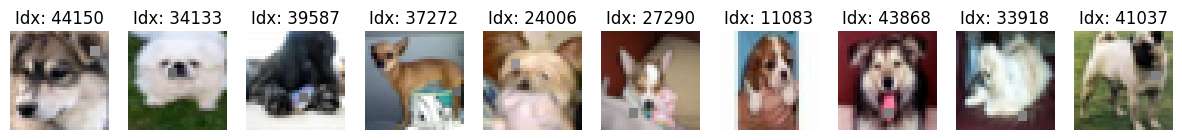

In [93]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(cifar_trainset, batch_size=64, shuffle=True)

# Selecting a target class and poisoning data
target_class = 5
num_samples_to_poison = 20
indices = [i for i, (_, label) in enumerate(cifar_trainset) if label == target_class]

if len(indices) < num_samples_to_poison:
    print("Not enough samples to poison.")
else:
    poisoned_dataset, poisoned_indices = poison_data(cifar_trainset, target_class, num_samples_to_poison)
    plot_poisoned_samples(poisoned_dataset, poisoned_indices)


In [94]:
def evaluate_models(model_paths, test_loader, poisoned_loader, device):
    models = load_models(model_paths, device)
    results = []

    for model in models:
        clean_accuracy, _, clean_labels = evaluate_model(test_loader, model, device)
        poisoned_accuracy, poisoned_preds, poisoned_labels = evaluate_model(poisoned_loader, model, device)

        clean_asr = calculate_asr(clean_labels, clean_preds, target_class)
        poisoned_asr = calculate_asr(poisoned_labels, poisoned_preds, target_class)
        
        results.append({
            'Model': model,
            'Clean Accuracy': clean_accuracy,
            'Poisoned Accuracy': poisoned_accuracy,
            'Clean ASR': clean_asr,
            'Poisoned ASR': poisoned_asr
        })

    return results


In [95]:
def unlearn_and_reevaluate(models, unlearn_loader, test_loader, device):
    reevaluated_results = []
    for model in models:
        train_model(unlearn_loader, model, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), device)
        post_unlearn_accuracy, post_unlearn_preds, post_unlearn_labels = evaluate_model(test_loader, model, device)
        post_unlearn_asr = calculate_asr(post_unlearn_labels, post_unlearn_preds, target_class)
        
        reevaluated_results.append({
            'Model': model,
            'Post-Unlearn Accuracy': post_unlearn_accuracy,
            'Post-Unlearn ASR': post_unlearn_asr
        })
    return reevaluated_results


In [96]:
def evaluate_clean_data(model, test_loader, device):
    """ Evaluate the model on the clean test dataset to establish a baseline performance. """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Pre-Poisoning Accuracy: {accuracy:.4f}")
    return accuracy


In [97]:
def evaluate_poisoned_data(model, poisoned_loader, device):
    """ Evaluate the model on the poisoned dataset to measure the impact of the backdoor. """
    model.eval()
    correct, total, misclassified_as_target = 0, 0, 0
    target_class = 3  # Example: the class we expect to be predicted due to the backdoor
    with torch.no_grad():
        for images, labels in poisoned_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            misclassified_as_target += (predicted == target_class).sum().item()
    
    accuracy = correct / total
    asr = misclassified_as_target / total  # Attack Success Rate
    print(f"Post-Poisoning Accuracy: {accuracy:.4f}")
    print(f"Attack Success Rate (ASR): {asr:.4f}")
    return accuracy, asr


In [98]:
# Assuming CIFAR-10 datasets are loaded and models are ready
target_class = 5
poisoned_dataset, poisoned_indices = poison_data(trainset, target_class, 500)

In [99]:
def calculate_asr(model, dataloader, device, target_class):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    misclassifications = total - correct
    return (misclassifications / total) * 100

In [104]:


def train_and_save_models_poison(shard_counts, slice_counts, trainset, testloader, device,target_class, subset_name=''):
    model_directory = f"./models{subset_name}"
    os.makedirs(model_directory, exist_ok=True)

    results = []
    total_steps = sum(shard_counts) * sum(slice_counts)
    
    with tqdm(total=total_steps, desc="Training Progress", unit="step", leave=False) as pbar:
        for S in shard_counts:
            for R in slice_counts:
                shards = shard_data(trainset, S)
                shard_models = []
                print(f"Training poisoned with {S} shards and {R} slices per shard")

                for i, shard in enumerate(shards):
                    model_path = f"{model_directory}/model_S{S}_R{R}_shard{i}.pth"
                    model_path_poison = f"{model_directory}/model_S{S}_R{R}_shard{i}_poison.pth"
                    
                    # Load the original model
                    model = get_model(device)
                    model.load_state_dict(torch.load(model_path))
                    model.to(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=0.001)
                    combined_dataset = []

                    for slice_ in shard_data(shard, R):
                        combined_dataset.extend(slice_.indices)
                        combined_subset = Subset(shard, combined_dataset)
                        trainloader = DataLoader(combined_subset, batch_size=64, shuffle=True)
                        train_model(trainloader, model, criterion, optimizer, 1,device)
                        pbar.update(1)
                    torch.save(model.state_dict(), model_path_poison)
                    shard_models.append(model_path_poison)

                # Evaluate and aggregate results after training or loading
                aggregated_results = evaluate_aggregated_models(shard_models, testloader, device)
                accuracy, precision, recall, f1, auroc = evaluate_model(testloader, model, device)
                # Calculate ASR if poisoned_dataset and target_class are provided
                if target_class is not None:
                    asr = calculate_asr(model, testloader, device, target_class)
                else:
                    asr = None
                results.append({
                    'S': S,
                    'R': R,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'AUROC': auroc,
                    'Model_Paths': shard_models,
                    'Aggregated_Results': aggregated_results,
                    'asr':asr
                })

    return results



In [105]:
target_class = 5  # Assuming class 3 is the target class for the poison
results = train_and_save_models_poison(shard_counts, slice_counts, poisoned_dataset, testloader, device, subset_name='', target_class=target_class)



Training Progress:   0%|          | 0/1225 [00:00<?, ?step/s]

Training poisoned with 5 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training poisoned with 5 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training poisoned with 5 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training poisoned with 10 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training poisoned with 10 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training poisoned with 10 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training poisoned with 20 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training poisoned with 20 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training poisoned with 20 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [123]:
print_aggregated_results_pretty(results)

+----+----+------------------+----------+-----------+--------+--------+--------+---------+
| S  | R  |      Method      | Accuracy | Precision | Recall |   F1   | AUROC  |   ASR   |
+----+----+------------------+----------+-----------+--------+--------+--------+---------+
| 5  | 5  |  Simple Average  |  0.6848  |   0.7225  | 0.6848 | 0.6741 | 0.9382 | 40.1000 |
| 5  | 5  | Weighted Average |  0.6870  |   0.7241  | 0.6870 | 0.6765 | 0.9382 | 40.1000 |
| 5  | 5  | Majority Voting  |  0.6704  |   0.7142  | 0.6704 | 0.6600 | 0.9382 | 40.1000 |
| 5  | 10 |  Simple Average  |  0.6964  |   0.7340  | 0.6964 | 0.6910 | 0.9038 | 34.5800 |
| 5  | 10 | Weighted Average |  0.6984  |   0.7354  | 0.6984 | 0.6928 | 0.9038 | 34.5800 |
| 5  | 10 | Majority Voting  |  0.6809  |   0.7262  | 0.6809 | 0.6776 | 0.9038 | 34.5800 |
| 5  | 20 |  Simple Average  |  0.7036  |   0.7359  | 0.7036 | 0.6990 | 0.9339 | 41.1000 |
| 5  | 20 | Weighted Average |  0.7061  |   0.7369  | 0.7061 | 0.7015 | 0.9339 | 41.1000 |

In [124]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset


def unlearn_data(shard_counts, slice_counts, trainset, testloader, device, forget_indices, target_class,subset_name=''):
    model_directory = f"./models{subset_name}"
    os.makedirs(model_directory, exist_ok=True)

    results = []
    total_steps = sum(shard_counts) * sum(slice_counts)
    
    with tqdm(total=total_steps, desc="Unlearning Progress", unit="step", leave=False) as pbar:
        for S in shard_counts:
            for R in slice_counts:
                shards = shard_data(trainset, S)
                shard_models = []
                print(f"Unlearning with {S} shards and {R} slices per shard")

                for i, shard in enumerate(shards):
                    slices = slice_shard(shard, R)
                    model_path = f"{model_directory}/model_S{S}_R{R}_shard{i}.pth"
                    unlearned_model_path = f"{model_directory}/model_S{S}_R{R}_shard{i}_unlearned2.pth"
                    

                    if not os.path.exists(model_path):
                        continue  # Skip if no original model is found

                    # Load the original model
                    model = get_model(device)
                    model.load_state_dict(torch.load(model_path))
                    model.to(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=0.001)

                    for slice_ in slices:
                        # Filter indices to exclude the forgotten ones
                        filtered_indices = [idx for idx in slice_.indices if idx not in forget_indices]
                        if not filtered_indices:
                            continue  # Skip training if no indices remain after filtering

                        combined_subset = Subset(trainset, filtered_indices)
                        trainloader = DataLoader(combined_subset, batch_size=32, shuffle=True)

                        train_model(trainloader, model, criterion, optimizer, 1,device)
                        pbar.update(1)

                    # Save the unlearned model state
                    torch.save(model.state_dict(), unlearned_model_path)
                    shard_models.append(unlearned_model_path)
                aggregated_results = evaluate_aggregated_models(shard_models, testloader, device)
                accuracy, precision, recall, f1, auroc = evaluate_model(testloader, model, device)
                # Evaluate and aggregate results after unlearning
                if shard_models and target_class is not None:
                    asr = calculate_asr(model, testloader, device, target_class)
                    print(asr)
                    
                else:
                    asr = None
                    print('no')
                results.append({
                    'S': S,
                    'R': R,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'AUROC': auroc,
                    'Model_Paths': shard_models,
                    'Aggregated_Results': aggregated_results,
                    'asr':asr
                })

    return results


In [125]:
target_class

5

In [126]:
# Run unlearning phase
results = unlearn_data(shard_counts, slice_counts, trainset, testloader, device,poisoned_indices,target_class)



Unlearning Progress:   0%|          | 0/1225 [00:00<?, ?step/s]

Unlearning with 5 shards and 5 slices per shard


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

48.32
Unlearning with 5 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

42.11
Unlearning with 5 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

45.910000000000004
Unlearning with 10 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

56.16
Unlearning with 10 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

41.91
Unlearning with 10 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

47.949999999999996
Unlearning with 20 shards and 5 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

55.53
Unlearning with 20 shards and 10 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

56.31
Unlearning with 20 shards and 20 slices per shard


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Aggregating Results:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

58.940000000000005


In [127]:
# Print the results
print_aggregated_results_pretty(results)

+----+----+------------------+----------+-----------+--------+--------+--------+---------+
| S  | R  |      Method      | Accuracy | Precision | Recall |   F1   | AUROC  |   ASR   |
+----+----+------------------+----------+-----------+--------+--------+--------+---------+
| 5  | 5  |  Simple Average  |  0.6331  |   0.6827  | 0.6331 | 0.6214 | 0.9040 | 48.3200 |
| 5  | 5  | Weighted Average |  0.6357  |   0.6849  | 0.6357 | 0.6242 | 0.9040 | 48.3200 |
| 5  | 5  | Majority Voting  |  0.6204  |   0.6692  | 0.6204 | 0.6082 | 0.9040 | 48.3200 |
| 5  | 10 |  Simple Average  |  0.6481  |   0.7093  | 0.6481 | 0.6441 | 0.9194 | 42.1100 |
| 5  | 10 | Weighted Average |  0.6549  |   0.7130  | 0.6549 | 0.6516 | 0.9194 | 42.1100 |
| 5  | 10 | Majority Voting  |  0.6439  |   0.7088  | 0.6439 | 0.6411 | 0.9194 | 42.1100 |
| 5  | 20 |  Simple Average  |  0.6789  |   0.7207  | 0.6789 | 0.6754 | 0.9296 | 45.9100 |
| 5  | 20 | Weighted Average |  0.6814  |   0.7204  | 0.6814 | 0.6776 | 0.9296 | 45.9100 |